In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
import gym 
import os
import copy
from collections import deque

import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
sess = tf.Session(config=config)  

In [191]:
class DQN(object) :
    def __init__(self , envName = "CartPole" ,version="v0" , prefix = "DQN") :
        self.prefix = prefix
        self.env = gym.make("{}-{}".format(envName,version))
        self.envName = envName
        self.modelName = "{}-{}".format(self.prefix,self.envName)
        self.modelPath = "./model/{}-{}.h5".format(self.prefix,self.envName)
        self.historyPath = "./history/{}.csv".format(self.modelName)
        self.memory = deque(maxlen = 3000)
        
        self.gamma = 0.9
        
        #epsilon for egreedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.model = self._buildModel()
        self.history = {"score":[]}
        
    def saveHistory(self,path=None):
        if path==None :
            path = self.historyPath
        pd.DataFrame(self.history).to_csv(path)
        print("save history in {}".format(path) )
    
    def loadHistory(self,path=None) :
        if path==None :
            path = self.historyPath
        assert os.path.exists(path)
        self.history["score"] = list(pd.read_csv(path)["score"])
        print("load history in {}".format(path) )
        
    def loadModel(self,path=None) :
        if path==None :
            path = self.modelPath
        assert os.path.exists(path) 
        self.model = tf.keras.models.load_model(path)
        self.epsilon = self.epsilon_min
        print("load model {} in {} success".format(self.modelName , path))
            
    def saveModel(self,path=None) :
        if path==None :
            path = self.modelPath
        self.model.save(path)
        print("save model {} success.".format(self.modelName ))
        
    def _buildModel(self) :
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64 , input_shape = self.env.observation_space.shape ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(128 ,activation="relu" ))
        model.add(tf.keras.layers.Dense(self.env.action_space.n ,activation="linear" ))
        model.compile(loss="mse", optimizer="adam" )
        model.summary()
        print("build model {} success".format(self.modelName))
        return model
    def act(self,state):
        if np.random.random() <= self.epsilon :
            return self.env.action_space.sample()
        else :
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append( (state, action, reward, next_state, done) )
    
    def update_epsilon(self):
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            if not done :
                reward += self.gamma * np.amax(self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
    
    def step(self,action) :
        next_state, reward, done, _ = self.env.step(action)
        next_state = self.getState(next_state)
        return next_state, reward, done, _
    
    def getReward(self,state, reward, done, eposide) :
        return -100 if done and eposide<200 else reward
    def getScore(self,score,state , reward , done) :
        return score+1
    def getState(self,state):
        return state.reshape(-1,self.env.observation_space.shape[0])
    def train(self, epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        done = False
        score = 0
        eposide = 0
        for epoch in range(epochs+1):
            # while not done :
            eposide += 1
            if render :
                self.env.render()
            action = agent.act(state)

            next_state, reward, done, _ = self.step(action)

            reward = self.getReward(state, reward, done,eposide)
            score = self.getScore(score,state , reward , done)

            agent.remember(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            if done :
                self.history["score"].append(score)
                print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                state  = self.env.reset()
                state = self.getState(state)
                score=0
                eposide = 0
                done = False

            if len(self.memory)>256 :
                self.replay(32) 
                self.update_epsilon()
            
        self.env.close()
    
    def play(self , epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        epoch = 0
        score = 0
        eposide = 0
        while epoch<epochs :
            eposide += 1
            if render :
                self.env.render()
            action = np.argmax(self.model.predict(state))
            next_state , reward , done , _ = self.step(action)
            
            reward = self.getReward(state , reward , done, eposide)
            score = self.getScore(score,state , reward , done)
            state = copy.deepcopy(next_state)
            
            if done :
                print( "epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                epoch += 1
                state  = self.env.reset()
                state = self.getState(state)
                score = 0
                eposide = 0
                done = False
                
        self.env.close()

In [222]:
class NatureDQN(DQN) : 
    def __init__(self,envName = "CartPole" ,version="v0" , prefix = "NatureDQN") :
        super().__init__(envName , version , prefix)
        self.target_model = self._buildModel()
        self.update_target_model()
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def replay(self , batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            ## next_action = self.model.predict(next_state)
            if not done :
                reward += self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target = self.target_model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)
    def train(self, epochs , render = False) :
        state  = self.env.reset()
        state = self.getState(state)
        done = False
        score = 0
        eposide = 0
        for epoch in range(epochs+1):
            # while not done :
            eposide += 1
            if render :
                self.env.render()
            action = agent.act(state)

            next_state, reward, done, _ = self.step(action)

            reward = self.getReward(state, reward, done,eposide)
            score = self.getScore(score,state , reward , done)

            agent.remember(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            if done :
                self.history["score"].append(score)
                print("epoch {} / {} played {} scores.".format(epoch ,epochs ,  score) )
                state  = self.env.reset()
                state = self.getState(state)
                score=0
                eposide = 0
                done = False

            if len(self.memory)>256 :
                self.replay(32)   
                self.update_target_model()
        
            if epoch%16 == 0 :
                self.update_epsilon()
                
            
        self.env.close()    
# agent = NatureDQN()

In [223]:
class DoubleDQN(NatureDQN) : 
    def __init__(self,envName = "CartPole" ,version="v0" , prefix = "DoubleDQN") :
        super().__init__(envName , version , prefix)
    def replay(self,batch_size) :
        batch_size = min(batch_size , len(self.memory))
        batches = np.random.choice(len(self.memory) , batch_size )
        for i in batches :
            state, action, reward, next_state, done = self.memory[i]
            next_action = np.argmax(self.model.predict(next_state))
            if not done :
                reward += self.gamma * self.target_model.predict(next_state)[0,next_action]
            target = self.target_model.predict(state)
            target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)

In [210]:
class MountainCar(DoubleDQN):
    def __init__(self):
        super().__init__("MountainCar")
    def getState(self,state) :
        return state.reshape(-1,self.env.observation_space.shape[0] )
    def getReward(self,state, reward, done,eposide) :    
        return 100 if  done and eposide<200 else np.sin(3*state[0,0])*0.5
    def getScore(self,score,state , reward , done) :
        return max(score,np.sin(3*state[0,0])*0.5+0.5 )
agent = MountainCar()
#agent.loadModel()
#agent.loadHistory()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_134 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_135 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_136 (Dense)            (None, 3)                 387       
Total params: 25,411
Trainable params: 25,411
Non-trainable params: 0
_________________________________________________________________
build model DoubleDQN-MountainCar success
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 64)                192       
______________________________

In [224]:
agent = DoubleDQN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 64)                320       
_________________________________________________________________
dense_150 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_151 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_152 (Dense)            (None, 2)                 258       
Total params: 25,410
Trainable params: 25,410
Non-trainable params: 0
_________________________________________________________________
build model DoubleDQN-CartPole success
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 64)                320       
_________________________________

In [229]:
%%time
agent.train(5000)
#agent.saveHistory()

epoch 14 / 5000 played 15 scores.
epoch 139 / 5000 played 125 scores.
epoch 173 / 5000 played 34 scores.
epoch 277 / 5000 played 104 scores.
epoch 310 / 5000 played 33 scores.
epoch 322 / 5000 played 12 scores.
epoch 449 / 5000 played 127 scores.
epoch 547 / 5000 played 98 scores.
epoch 562 / 5000 played 15 scores.
epoch 677 / 5000 played 115 scores.
epoch 803 / 5000 played 126 scores.
epoch 940 / 5000 played 137 scores.
epoch 1101 / 5000 played 161 scores.
epoch 1244 / 5000 played 143 scores.
epoch 1367 / 5000 played 123 scores.
epoch 1487 / 5000 played 120 scores.
epoch 1532 / 5000 played 45 scores.
epoch 1634 / 5000 played 102 scores.
epoch 1834 / 5000 played 200 scores.
epoch 2032 / 5000 played 198 scores.
epoch 2162 / 5000 played 130 scores.
epoch 2362 / 5000 played 200 scores.
epoch 2388 / 5000 played 26 scores.
epoch 2406 / 5000 played 18 scores.
epoch 2606 / 5000 played 200 scores.
epoch 2726 / 5000 played 120 scores.
epoch 2926 / 5000 played 200 scores.
epoch 2950 / 5000 playe

In [234]:
agent.saveModel()
agent.saveHistory()

save model DoubleDQN-CartPole success.
save history in ./history/DoubleDQN-CartPole.csv


In [235]:
agent.play(5 , True)

epoch 0 / 5 played 200 scores.
epoch 1 / 5 played 200 scores.
epoch 2 / 5 played 164 scores.
epoch 3 / 5 played 163 scores.
epoch 4 / 5 played 173 scores.


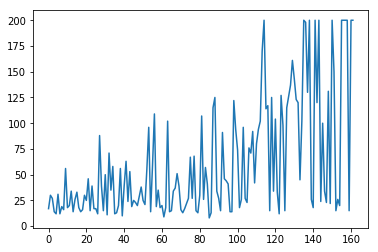

In [233]:
plt.plot(agent.history["score"])

In [75]:
state = agent.env.reset()
state.shape

(210, 160, 3)

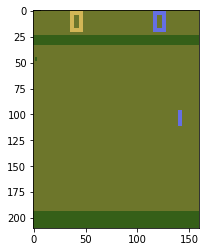

In [76]:
plt.imshow(state)

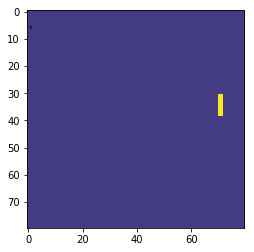

In [79]:
grayState = np.zeros((state.shape[0]//2 , state.shape[1]//2))
for i in range(0,state.shape[0],2) :
    for j in range(0,state.shape[1],2) :
            grayState[i//2,j//2] = np.max(state[i:i+2,j:j+2,:]) /255
grayState = grayState[17:-8,:]
plt.imshow(grayState)

In [106]:
agent.env.close()

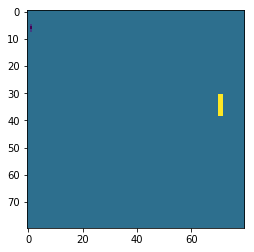

In [59]:
state , _,_,_,_ = agent.memory[0]
plt.imshow(state.reshape(80,80))

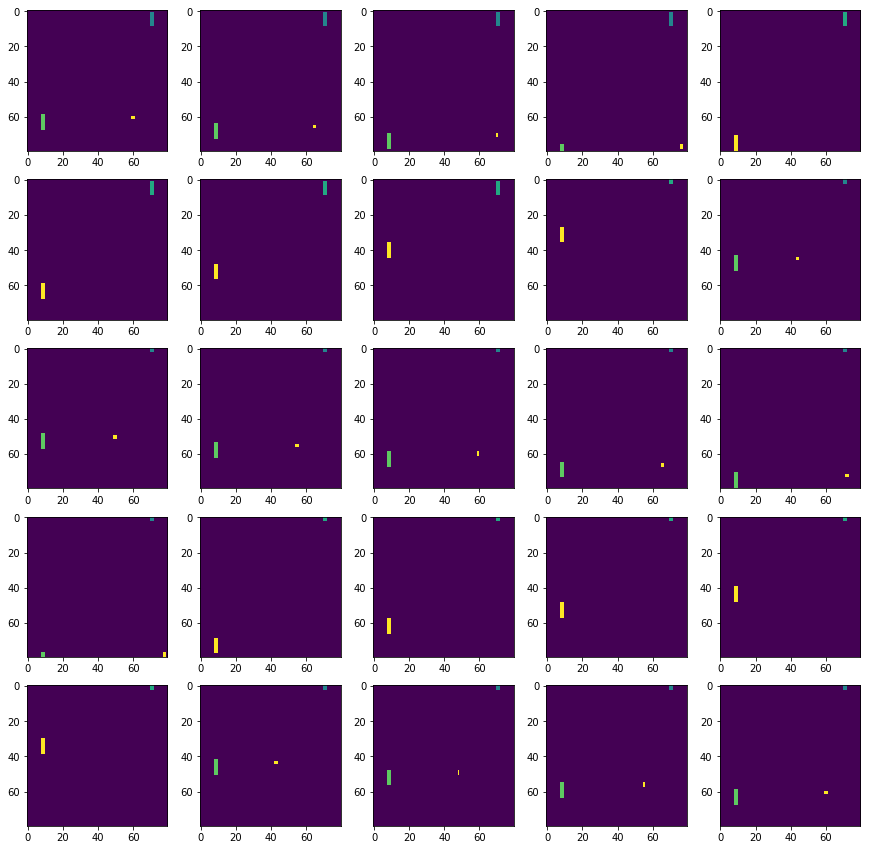

In [84]:
plt.figure(figsize=(15,15))
for i in range(5) :
    for j in range(5) :
        plt.subplot(5,5,5*i+j+1)
        state,_,_,_,_, = agent.memory[1000+i*5+j] 
        plt.imshow(state.reshape(80,80))

In [115]:
historyOld = agent.history

In [207]:
state, action, reward, next_state, done =  agent.memory[0]
state

array([[-0.45194285,  0.        ]])

In [208]:
# next_action = 
agent.model.predict(next_state)[0]

array([[-0.01298903,  0.01822895,  0.0157926 ]], dtype=float32)